Bus Reliability
==========
I take the bus home from work, and the schedule can't always be trusted. I figured I would start collecting some data on my bus at about the time I take it home from work. I've targetted it pretty narrowly because the live transit feed data discourages mass data gathering.

I made a script to gather data from [OC Transpo's live transit feed](http://www.octranspo.com/developers) and store it in an SQLite database (ocbusdata.db). I've been running this as a scheduled task, it starts up at about 4pm every day and runs for an hour, checking the estimated arrival time more frequently as the bus gets closer.

I then need to link this with the schedule data, as the live feed data doesn't actually include what time the trip was scheduled to arrive.

So far this is based on weekdays, between 4 and 5pm, from October 4th 2016 to October 12th 2016.

In [1]:
import pandas as pd
from Tables import Trip, Estimate, Base

from sqlalchemy.orm import sessionmaker
from sqlalchemy.ext.declarative import declarative_base
from sqlalchemy import create_engine

Step one is to connect to the database of live transit data

In [2]:
engine = create_engine('sqlite:///ocbusdata.db')
Base.metadata.bind = engine
DBSession = sessionmaker(bind=engine)
session = DBSession()

In [3]:
query = session.query(Trip, Estimate).join(Estimate)
print(query.statement)
bus_live_data = pd.read_sql(query.statement, query.session.bind)

bus_live_data.columns.values

SELECT trips.id, trips.route, trips.route_label, trips.start_time, estimates.estimate_id, estimates.trip_id, estimates.stop_id, estimates.estimate_processing_time, estimates.adjusted_schedule_time, estimates.adjustment_age, estimates.latitude, estimates.longitude 
FROM trips JOIN estimates ON trips.id = estimates.trip_id


array(['id', 'route', 'route_label', 'start_time', 'estimate_id',
       'trip_id', 'stop_id', 'estimate_processing_time',
       'adjusted_schedule_time', 'adjustment_age', 'latitude', 'longitude'], dtype=object)

Basically what I have is a series of estimates for different trips. Each time I call the API I get back estimates for the next 3 trips, so I have lots of estimates per trip. "adjusted_schedule_time" is the estimated number of minutes until the bus arrives, and "estimate_processing_time" is the time the request was processed on the server.

In [4]:
bus_live_data.head(10)

,id,route,route_label,start_time,estimate_id,trip_id,stop_id,estimate_processing_time,adjusted_schedule_time,adjustment_age,latitude,longitude
0,7,85,Bayshore,15:31:00,70,7,6653,2016-10-04 15:58:02,2,0.41,45.407509,-75.713688
1,8,85,Bayshore,15:46:00,71,8,6653,2016-10-04 15:58:02,18,0.74,45.424884,-75.683978
2,9,85,Bayshore,16:01:00,72,9,6653,2016-10-04 15:58:02,33,3.84,45.416420,-75.669496
3,7,85,Bayshore,15:31:00,73,7,6653,2016-10-04 15:59:15,1,0.50,45.405422,-75.712427
4,8,85,Bayshore,15:46:00,74,8,6653,2016-10-04 15:59:15,17,0.90,45.424734,-75.684338
5,9,85,Bayshore,16:01:00,75,9,6653,2016-10-04 15:59:15,32,5.05,45.416420,-75.669496
6,8,85,Bayshore,15:46:00,76,8,6653,2016-10-04 16:00:40,17,0.78,45.423725,-75.686666
7,9,85,Bayshore,16:01:00,77,9,6653,2016-10-04 16:00:40,31,6.48,45.416420,-75.669496
8,10,85,Bayshore,16:16:00,78,10,6653,2016-10-04 16:00:40,42,-1.00,NaN,NaN
9,8,85,Bayshore,15:46:00,79,8,6653,2016-10-04 16:06:01,12,0.59,45.421634,-75.696356


I created a database of the google transit feed using [pygtfs](http://pygtfs.readthedocs.io/en/latest/index.html), but I decided it was easier to query that database directly than via the library.
I also created an aditional view: 

`CREATE VIEW trip_start_times AS SELECT trip_id, arrival_time as start_time FROM stop_times WHERE stop_sequence= 1`

In [5]:
import sqlite3

conn = sqlite3.connect('gtfs2.db') 
c = conn.cursor();

The GTFS database uses route and stop ids that aren't the ones posted on the bus and the stop, so look up these internal ids from the route number (85) and stop number (6653)

In [6]:
route_id = c.execute("SELECT route_id FROM routes WHERE route_short_name = '85'").fetchone()[0]
stop_id = c.execute("SELECT stop_id FROM stops WHERE stop_code = '6653'").fetchone()[0]

I want all of the start times for regular weekday service, and the time that trip is scheduled to arrive at my stop. Unfortunately start_time is the only way I have to link the GTFS schedule with the live data.

In [7]:
service_id = "SEPT16-SEPDA16-Weekday-36" # Regular weekday service
start_times_query = "SELECT stop_times.trip_id, start_time, arrival_time " \
"FROM stop_times JOIN trip_start_times on stop_times.trip_id = trip_start_times.trip_id "\
"WHERE stop_id = ? and stop_times.trip_id in (SELECT trip_id from trips where route_id = ? and service_id=?)"
schedule_start_times = pd.read_sql(start_times_query, conn, params=(stop_id,route_id,service_id))
schedule_start_times.head(5)

,stop_times.trip_id,start_time,arrival_time
0,43028550-SEPT16-SEPDA16-Weekday-36,1970-01-01 12:18:00.000000,1970-01-01 12:41:00.000000
1,43028608-SEPT16-SEPDA16-Weekday-36,1970-01-01 18:16:00.000000,1970-01-01 18:38:00.000000
2,43029106-SEPT16-SEPDA16-Weekday-36,1970-01-01 17:46:00.000000,1970-01-01 18:11:00.000000
3,43029132-SEPT16-SEPDA16-Weekday-36,1970-01-01 20:48:00.000000,1970-01-01 21:09:00.000000
4,43029134-SEPT16-SEPDA16-Weekday-36,1970-01-01 22:32:00.000000,1970-01-01 22:53:00.000000


So now we need to link two tables based on a time! And one of our tables as this as a time, and one as a formatted string including a garbage date. This is probably easier as a string comparison

In [8]:
bus_live_data["start_time_string"] = bus_live_data["start_time"].astype(str)
bus_live_data["start_time_string"].head(3)

0    15:31:00
1    15:46:00
2    16:01:00
Name: start_time_string, dtype: object

This one has the date as a formatted string, with a useless date. So I parse it as a date and then format it as a time-only string.

In [9]:

schedule_start_times["start_time_date"] = pd.to_datetime(schedule_start_times["start_time"], format='%Y-%m-%d %H:%M:%S.%f')
schedule_start_times["start_time_string"] = schedule_start_times["start_time_date"].apply(lambda x: x.strftime("%H:%M:%S"))

In [10]:
schedule_start_times["start_time_string"].head(3)

0    12:18:00
1    18:16:00
2    17:46:00
Name: start_time_string, dtype: object

Now we can merge the schedule with the live data on the time string.

In [11]:
with_scheduled_arrival_time = pd.merge(bus_live_data, schedule_start_times, how="left", on="start_time_string")

In [12]:
with_scheduled_arrival_time.head(5)

,id,route,route_label,start_time_x,estimate_id,trip_id,stop_id,estimate_processing_time,adjusted_schedule_time,adjustment_age,latitude,longitude,start_time_string,stop_times.trip_id,start_time_y,arrival_time,start_time_date
0,7,85,Bayshore,15:31:00,70,7,6653,2016-10-04 15:58:02,2,0.41,45.407509,-75.713688,15:31:00,43029734-SEPT16-SEPDA16-Weekday-36,1970-01-01 15:31:00.000000,1970-01-01 15:57:00.000000,1970-01-01 15:31:00
1,8,85,Bayshore,15:46:00,71,8,6653,2016-10-04 15:58:02,18,0.74,45.424884,-75.683978,15:46:00,43032887-SEPT16-SEPDA16-Weekday-36,1970-01-01 15:46:00.000000,1970-01-01 16:12:00.000000,1970-01-01 15:46:00
2,9,85,Bayshore,16:01:00,72,9,6653,2016-10-04 15:58:02,33,3.84,45.416420,-75.669496,16:01:00,43031864-SEPT16-SEPDA16-Weekday-36,1970-01-01 16:01:00.000000,1970-01-01 16:31:00.000000,1970-01-01 16:01:00
3,7,85,Bayshore,15:31:00,73,7,6653,2016-10-04 15:59:15,1,0.50,45.405422,-75.712427,15:31:00,43029734-SEPT16-SEPDA16-Weekday-36,1970-01-01 15:31:00.000000,1970-01-01 15:57:00.000000,1970-01-01 15:31:00
4,8,85,Bayshore,15:46:00,74,8,6653,2016-10-04 15:59:15,17,0.90,45.424734,-75.684338,15:46:00,43032887-SEPT16-SEPDA16-Weekday-36,1970-01-01 15:46:00.000000,1970-01-01 16:12:00.000000,1970-01-01 15:46:00


In [13]:
with_scheduled_arrival_time["estimate_processing_time"] = \
pd.to_datetime(with_scheduled_arrival_time["estimate_processing_time"], format='%Y-%m-%d %H:%M:%S')
with_scheduled_arrival_time["estimated_arrival_time"] = with_scheduled_arrival_time["estimate_processing_time"] +\
with_scheduled_arrival_time["adjusted_schedule_time"].apply(pd.offsets.Minute)

/Users/lgaud/anaconda/lib/python3.5/site-packages/pandas/core/ops.py:533: PerformanceWarning: Adding/subtracting array of DateOffsets to Series not vectorized
  "Series not vectorized", PerformanceWarning)


The live feed data gives us an estimated number of minutes until arrival, not the estimated arrival time. So we calculate the estimated arrival time using the `adjusted_schedule_time` and `estimate_processing_time`.

And then we need the scheduled arrival time as a full date so we can compare them. This code assumes that the estimated time and scheduled time are the same day; good thing I don't leave work at midnight!

In [14]:
with_scheduled_arrival_time["scheduled_arrival_time"] = \
    pd.to_datetime(with_scheduled_arrival_time["arrival_time"], format='%Y-%m-%d %H:%M:%S.%f')
with_scheduled_arrival_time["scheduled_arrival_time"] = with_scheduled_arrival_time["scheduled_arrival_time"].dt.time
with_scheduled_arrival_time.head(5)

,id,route,route_label,start_time_x,estimate_id,trip_id,stop_id,estimate_processing_time,adjusted_schedule_time,adjustment_age,latitude,longitude,start_time_string,stop_times.trip_id,start_time_y,arrival_time,start_time_date,estimated_arrival_time,scheduled_arrival_time
0,7,85,Bayshore,15:31:00,70,7,6653,2016-10-04 15:58:02,2,0.41,45.407509,-75.713688,15:31:00,43029734-SEPT16-SEPDA16-Weekday-36,1970-01-01 15:31:00.000000,1970-01-01 15:57:00.000000,1970-01-01 15:31:00,2016-10-04 16:00:02,15:57:00
1,8,85,Bayshore,15:46:00,71,8,6653,2016-10-04 15:58:02,18,0.74,45.424884,-75.683978,15:46:00,43032887-SEPT16-SEPDA16-Weekday-36,1970-01-01 15:46:00.000000,1970-01-01 16:12:00.000000,1970-01-01 15:46:00,2016-10-04 16:16:02,16:12:00
2,9,85,Bayshore,16:01:00,72,9,6653,2016-10-04 15:58:02,33,3.84,45.416420,-75.669496,16:01:00,43031864-SEPT16-SEPDA16-Weekday-36,1970-01-01 16:01:00.000000,1970-01-01 16:31:00.000000,1970-01-01 16:01:00,2016-10-04 16:31:02,16:31:00
3,7,85,Bayshore,15:31:00,73,7,6653,2016-10-04 15:59:15,1,0.50,45.405422,-75.712427,15:31:00,43029734-SEPT16-SEPDA16-Weekday-36,1970-01-01 15:31:00.000000,1970-01-01 15:57:00.000000,1970-01-01 15:31:00,2016-10-04 16:00:15,15:57:00
4,8,85,Bayshore,15:46:00,74,8,6653,2016-10-04 15:59:15,17,0.90,45.424734,-75.684338,15:46:00,43032887-SEPT16-SEPDA16-Weekday-36,1970-01-01 15:46:00.000000,1970-01-01 16:12:00.000000,1970-01-01 15:46:00,2016-10-04 16:16:15,16:12:00


In [15]:
with_scheduled_arrival_time["estimated_date"] = with_scheduled_arrival_time["estimated_arrival_time"].dt.date

In [16]:
with_scheduled_arrival_time["estimated_date"].head(3)

0    2016-10-04
1    2016-10-04
2    2016-10-04
Name: estimated_date, dtype: object

In [17]:
with_scheduled_arrival_time["scheduled_date_time"] = \
with_scheduled_arrival_time.apply(lambda r : pd.datetime.combine(r['estimated_date'],r['scheduled_arrival_time']),1)
with_scheduled_arrival_time["scheduled_date_time"].head(3)


0   2016-10-04 15:57:00
1   2016-10-04 16:12:00
2   2016-10-04 16:31:00
Name: scheduled_date_time, dtype: datetime64[ns]

Now we want to figure out how far off the estimate is from the scheduled time. Datetime math is fun!

In [18]:
with_scheduled_arrival_time["minutes_off_sched"] = (with_scheduled_arrival_time["estimated_arrival_time"]\
- with_scheduled_arrival_time["scheduled_date_time"])


In [19]:
with_scheduled_arrival_time["minutes_off_sched"] = pd.to_timedelta(with_scheduled_arrival_time["minutes_off_sched"])\
.dt.total_seconds() / 60 
with_scheduled_arrival_time.head(5)


,id,route,route_label,start_time_x,estimate_id,trip_id,stop_id,estimate_processing_time,adjusted_schedule_time,adjustment_age,...,start_time_string,stop_times.trip_id,start_time_y,arrival_time,start_time_date,estimated_arrival_time,scheduled_arrival_time,estimated_date,scheduled_date_time,minutes_off_sched
0,7,85,Bayshore,15:31:00,70,7,6653,2016-10-04 15:58:02,2,0.41,...,15:31:00,43029734-SEPT16-SEPDA16-Weekday-36,1970-01-01 15:31:00.000000,1970-01-01 15:57:00.000000,1970-01-01 15:31:00,2016-10-04 16:00:02,15:57:00,2016-10-04,2016-10-04 15:57:00,3.033333
1,8,85,Bayshore,15:46:00,71,8,6653,2016-10-04 15:58:02,18,0.74,...,15:46:00,43032887-SEPT16-SEPDA16-Weekday-36,1970-01-01 15:46:00.000000,1970-01-01 16:12:00.000000,1970-01-01 15:46:00,2016-10-04 16:16:02,16:12:00,2016-10-04,2016-10-04 16:12:00,4.033333
2,9,85,Bayshore,16:01:00,72,9,6653,2016-10-04 15:58:02,33,3.84,...,16:01:00,43031864-SEPT16-SEPDA16-Weekday-36,1970-01-01 16:01:00.000000,1970-01-01 16:31:00.000000,1970-01-01 16:01:00,2016-10-04 16:31:02,16:31:00,2016-10-04,2016-10-04 16:31:00,0.033333
3,7,85,Bayshore,15:31:00,73,7,6653,2016-10-04 15:59:15,1,0.50,...,15:31:00,43029734-SEPT16-SEPDA16-Weekday-36,1970-01-01 15:31:00.000000,1970-01-01 15:57:00.000000,1970-01-01 15:31:00,2016-10-04 16:00:15,15:57:00,2016-10-04,2016-10-04 15:57:00,3.250000
4,8,85,Bayshore,15:46:00,74,8,6653,2016-10-04 15:59:15,17,0.90,...,15:46:00,43032887-SEPT16-SEPDA16-Weekday-36,1970-01-01 15:46:00.000000,1970-01-01 16:12:00.000000,1970-01-01 15:46:00,2016-10-04 16:16:15,16:12:00,2016-10-04,2016-10-04 16:12:00,4.250000


How close to the scheduled time do buses actually arrive?
------------------------------------------------------
For my first analysis, I want to see how close to the scheduled time the buses are actually arriving. For that, I want to look at the last estimate I have for each trip.

In [20]:
grouped = with_scheduled_arrival_time.groupby(["trip_id", "estimated_date"])
last_estimates = with_scheduled_arrival_time[with_scheduled_arrival_time['estimate_processing_time'] ==  grouped['estimate_processing_time'].transform(max)]
last_estimates

,id,route,route_label,start_time_x,estimate_id,trip_id,stop_id,estimate_processing_time,adjusted_schedule_time,adjustment_age,...,start_time_string,stop_times.trip_id,start_time_y,arrival_time,start_time_date,estimated_arrival_time,scheduled_arrival_time,estimated_date,scheduled_date_time,minutes_off_sched
3,7,85,Bayshore,15:31:00,73,7,6653,2016-10-04 15:59:15,1,0.50,...,15:31:00,43029734-SEPT16-SEPDA16-Weekday-36,1970-01-01 15:31:00.000000,1970-01-01 15:57:00.000000,1970-01-01 15:31:00,2016-10-04 16:00:15,15:57:00,2016-10-04,2016-10-04 15:57:00,3.250000
21,8,85,Bayshore,15:46:00,91,8,6653,2016-10-04 16:18:45,1,0.76,...,15:46:00,43032887-SEPT16-SEPDA16-Weekday-36,1970-01-01 15:46:00.000000,1970-01-01 16:12:00.000000,1970-01-01 15:46:00,2016-10-04 16:19:45,16:12:00,2016-10-04,2016-10-04 16:12:00,7.750000
36,9,85,Bayshore,16:01:00,106,9,6653,2016-10-04 16:31:16,2,0.78,...,16:01:00,43031864-SEPT16-SEPDA16-Weekday-36,1970-01-01 16:01:00.000000,1970-01-01 16:31:00.000000,1970-01-01 16:01:00,2016-10-04 16:33:16,16:31:00,2016-10-04,2016-10-04 16:31:00,2.266667
63,10,85,Bayshore,16:16:00,133,10,6653,2016-10-04 16:52:14,1,0.52,...,16:16:00,43032313-SEPT16-SEPDA16-Weekday-36,1970-01-01 16:16:00.000000,1970-01-01 16:43:00.000000,1970-01-01 16:16:00,2016-10-04 16:53:14,16:43:00,2016-10-04,2016-10-04 16:43:00,10.233333
68,11,85,Bayshore,16:31:00,139,11,6653,2016-10-04 16:58:53,14,0.51,...,16:31:00,43032859-SEPT16-SEPDA16-Weekday-36,1970-01-01 16:31:00.000000,1970-01-01 16:58:00.000000,1970-01-01 16:31:00,2016-10-04 17:12:53,16:58:00,2016-10-04,2016-10-04 16:58:00,14.883333
69,12,85,Bayshore,16:46:00,140,12,6653,2016-10-04 16:58:53,24,0.43,...,16:46:00,43032446-SEPT16-SEPDA16-Weekday-36,1970-01-01 16:46:00.000000,1970-01-01 17:13:00.000000,1970-01-01 16:46:00,2016-10-04 17:22:53,17:13:00,2016-10-04,2016-10-04 17:13:00,9.883333
88,7,85,Bayshore,15:31:00,160,7,6653,2016-10-05 16:07:11,1,0.18,...,15:31:00,43029734-SEPT16-SEPDA16-Weekday-36,1970-01-01 15:31:00.000000,1970-01-01 15:57:00.000000,1970-01-01 15:31:00,2016-10-05 16:08:11,15:57:00,2016-10-05,2016-10-05 15:57:00,11.183333
106,8,85,Bayshore,15:46:00,178,8,6653,2016-10-05 16:16:08,1,0.40,...,15:46:00,43032887-SEPT16-SEPDA16-Weekday-36,1970-01-01 15:46:00.000000,1970-01-01 16:12:00.000000,1970-01-01 15:46:00,2016-10-05 16:17:08,16:12:00,2016-10-05,2016-10-05 16:12:00,5.133333
124,9,85,Bayshore,16:01:00,196,9,6653,2016-10-05 16:34:02,2,0.28,...,16:01:00,43031864-SEPT16-SEPDA16-Weekday-36,1970-01-01 16:01:00.000000,1970-01-01 16:31:00.000000,1970-01-01 16:01:00,2016-10-05 16:36:02,16:31:00,2016-10-05,2016-10-05 16:31:00,5.033333
137,11,85,Bayshore,16:31:00,214,11,6653,2016-10-05 17:01:43,9,0.36,...,16:31:00,43032859-SEPT16-SEPDA16-Weekday-36,1970-01-01 16:31:00.000000,1970-01-01 16:58:00.000000,1970-01-01 16:31:00,2016-10-05 17:10:43,16:58:00,2016-10-05,2016-10-05 16:58:00,12.716667


In [21]:
last_estimates["minutes_off_sched"].describe()

count    37.000000
mean     10.701351
std       8.435172
min      -0.050000
25%       4.916667
50%       9.016667
75%      13.566667
max      31.783333
Name: minutes_off_sched, dtype: float64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x112cb3240>]], dtype=object)

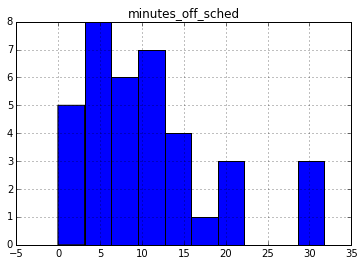

In [22]:
%matplotlib inline
last_estimates.hist("minutes_off_sched")

The mean arrival time is over 10 minutes late, for a bus that is scheduled to come every 15 minutes!

Which trip is furthest off schedule?
----------------------------------

In [23]:
last_estimates[last_estimates["minutes_off_sched"] == last_estimates["minutes_off_sched"].max()]

,id,route,route_label,start_time_x,estimate_id,trip_id,stop_id,estimate_processing_time,adjusted_schedule_time,adjustment_age,...,start_time_string,stop_times.trip_id,start_time_y,arrival_time,start_time_date,estimated_arrival_time,scheduled_arrival_time,estimated_date,scheduled_date_time,minutes_off_sched
166,15,85,Bayshore,15:16:00,244,15,6653,2016-10-06 16:11:47,1,0.29,...,15:16:00,43034068-SEPT16-SEPDA16-Weekday-36,1970-01-01 15:16:00.000000,1970-01-01 15:41:00.000000,1970-01-01 15:16:00,2016-10-06 16:12:47,15:41:00,2016-10-06,2016-10-06 15:41:00,31.783333


Are some trips consistently late?
--------------------------------

Note: Due to how this data is gathered, the trip that starts at 15:16 will only be captured if it is quite late, and the 16:46 trip (and sometimes a couple earlier trips) is an estimate quite far out from when it actually arrives.


In [24]:
last_estimates.groupby("scheduled_arrival_time")[["minutes_off_sched", "adjusted_schedule_time"]].describe()

minutes_off_sched  adjusted_schedule_time
scheduled_arrival_time                                                 
15:41:00               count           3.000000                3.000000
                       mean           28.222222                1.000000
                       std             5.726409                0.000000
                       min            21.616667                1.000000
                       25%            26.441667                1.000000
                       50%            31.266667                1.000000
                       75%            31.525000                1.000000
                       max            31.783333                1.000000
15:57:00               count           5.000000                5.000000
                       mean            6.383333                1.000000
                       std             3.266305                0.000000
                       min             3.250000                1.000000
                       25%             3.400000                1.000000
                       50%             6.883333                1.000000
                       75%             7.200000                1.000000
                       max            11.183333                1.000000
16:12:00               count           6.000000                6.000000
                       mean            8.405556                1.000000
                       std             5.091733                0.000000
                       min             0.783333                1.000000
                       25%             5.787500                1.000000
                       50%             8.383333                1.000000
                       75%            12.429167                1.000000
                       max            14.183333                1.000000
16:31:00               count           6.000000                6.000000
                       mean            6.361111                1.500000
                       std             3.513398                0.547723
                       min             2.266667                1.000000
                       25%             4.945833                1.000000
                       50%             5.425000                1.500000
                       75%             7.066667                2.000000
                       max            12.650000                2.000000
16:43:00               count           6.000000                6.000000
                       mean           14.186111                6.666667
                       std            10.429181                8.869423
                       min             3.283333                1.000000
                       25%             8.395833                1.000000
                       50%            10.541667                1.500000
                       75%            18.650000               10.250000
                       max            31.716667               22.000000
16:58:00               count           6.000000                6.000000
                       mean           13.530556               11.333333
                       std             5.970254                5.750362
                       min             4.500000                3.000000
                       25%            10.804167                9.000000
                       50%            13.800000               11.000000
                       75%            16.433333               13.750000
                       max            21.966667               20.000000
17:13:00               count           5.000000                5.000000
                       mean            4.893333               18.000000
                       std             4.781164                5.787918
                       min            -0.050000               11.000000
                       25%             1.966667               15.000000
                       50%             2.500000               16.00000

Only the 16:12 bus is ever on time, and 16:43 and 16:58 buses are typically 10 minutes late.

The 16:58 bus is, as of about it's scheduled arrival time, predicted to arrive over 13 minutes late half the time. Based on experience, I would say that it's not usually that late in practice, as the buses frequently do gain on their predicted time that far out.

How accurate are the API's estimated arrival times?
----------------------------------

It's been my experience that many days, the predictions seem to get later and later, until somewhere around 10 minutes out, when the bus starts catching up.

Compare the last estimated time for a trip to the different estimates

In [25]:
with_scheduled_arrival_time.groupby(["trip_id", "scheduled_date_time"])["minutes_off_sched", "estimated_arrival_time", "scheduled_arrival_time"].max()

minutes_off_sched estimated_arrival_time  \
trip_id scheduled_date_time                                             
7       2016-10-04 15:57:00           3.250000    2016-10-04 16:00:15   
        2016-10-05 15:57:00          12.100000    2016-10-05 16:09:06   
        2016-10-06 15:57:00           7.200000    2016-10-06 16:04:12   
        2016-10-07 15:57:00           6.883333    2016-10-07 16:03:53   
        2016-10-11 15:57:00           3.400000    2016-10-11 16:00:24   
8       2016-10-04 16:12:00           8.283333    2016-10-04 16:20:17   
        2016-10-05 16:12:00           5.383333    2016-10-05 16:17:23   
        2016-10-06 16:12:00           0.883333    2016-10-06 16:12:53   
        2016-10-07 16:12:00          14.450000    2016-10-07 16:26:27   
        2016-10-11 16:12:00          10.516667    2016-10-11 16:22:31   
        2016-10-12 16:12:00          14.183333    2016-10-12 16:26:11   
9       2016-10-04 16:31:00           4.850000    2016-10-04 16:35:51   
        2016-10-05 16:31:00           6.900000    2016-10-05 16:37:54   
        2016-10-06 16:31:00          12.650000    2016-10-06 16:43:39   
        2016-10-07 16:31:00          10.566667    2016-10-07 16:41:34   
        2016-10-11 16:31:00           7.133333    2016-10-11 16:38:08   
        2016-10-12 16:31:00          10.616667    2016-10-12 16:41:37   
10      2016-10-04 16:43:00          10.233333    2016-10-04 16:53:14   
        2016-10-05 16:43:00          31.716667    2016-10-05 17:14:43   
        2016-10-06 16:43:00           3.283333    2016-10-06 16:46:17   
        2016-10-07 16:43:00          11.733333    2016-10-07 16:54:44   
        2016-10-11 16:43:00          21.250000    2016-10-11 17:04:15   
        2016-10-12 16:43:00           8.733333    2016-10-12 16:51:44   
11      2016-10-04 16:58:00          14.883333    2016-10-04 17:12:53   
        2016-10-05 16:58:00          12.716667    2016-10-05 17:10:43   
        2016-10-06 16:58:00          21.966667    2016-10-06 17:19:58   
        2016-10-07 16:58:00          10.166667    2016-10-07 17:08:10   
        2016-10-11 16:58:00           5.633333    2016-10-11 17:03:38   
        2016-10-12 16:58:00          16.966667    2016-10-12 17:14:58   
12      2016-10-04 17:13:00           9.883333    2016-10-04 17:22:53   
        2016-10-06 17:13:00           1.966667    2016-10-06 17:14:58   
        2016-10-07 17:13:00          10.166667    2016-10-07 17:23:10   
        2016-10-11 17:13:00           3.000000    2016-10-11 17:16:00   
        2016-10-12 17:13:00           0.566667    2016-10-12 17:13:34   
15      2016-10-06 15:41:00          31.783333    2016-10-06 16:12:47   
        2016-10-07 15:41:00          21.616667    2016-10-07 16:02:37   
        2016-10-11 15:41:00          31.266667    2016-10-11 16:12:16   

                            scheduled_arrival_time  
trip_id scheduled_date_time                         
7       2016-10-04 15:57:00               15:57:00  
        2016-10-05 15:57:00               15:57:00  
        2016-10-06 15:57:00               15:57:00  
        2016-10-07 15:57:00               15:57:00  
        2016-10-11 15:57:00               15:57:00  
8       2016-10-04 16:12:00               16:12:00  
        2016-10-05 16:12:00               16:12:00  
        2016-10-06 16:12:00               16:12:00  
        2016-10-07 16:12:00               16:12:00  
        2016-10-11 16:12:00               16:12:00  
        2016-10-12 16:12:00               16:12:00  
9       2016-10-04 16:31:00               16:31:00  
        2016-10-05 16:31:00               16:31:00  
        2016-10-06 16:31:00               16:31:00  
        2016-10-07 16:31:00               16:31:00  
        2016-10-11 16:31:00               16:31:00  
        2016-10-12 16:31:00               16:31:00  
10      2016-10-04 16:43:00               16:43:00  
        2016-10-05 16:43:00               16:43:00  
        2016-10-06 16:43:00               16:43:00  
        2016-10

I am calling a last estimate "reliable" if it was estimating an arrival within 3 minutes. This removes the trips that actually arrived well outside of the window I was gathering data for.

In [26]:
reliable_last_estimates = last_estimates[last_estimates["adjusted_schedule_time"] <= 3]
reliable_last_estimates.describe()

,id,estimate_id,trip_id,stop_id,adjusted_schedule_time,adjustment_age,latitude,longitude,minutes_off_sched
count,25.000000,25.00000,25.000000,25.0,25.000000,25.000000,24.000000,24.000000,25.000000
mean,9.320000,365.60000,9.320000,6653.0,1.240000,0.684000,45.406314,-75.712534,9.673333
std,2.410394,222.07206,2.410394,0.0,0.522813,1.259176,0.002439,0.001100,7.995430
min,7.000000,73.00000,7.000000,6653.0,1.000000,-1.000000,45.404645,-75.715161,0.783333
25%,8.000000,196.00000,8.000000,6653.0,1.000000,0.370000,45.405266,-75.713254,4.916667
50%,9.000000,301.00000,9.000000,6653.0,1.000000,0.500000,45.405323,-75.712345,7.483333
75%,10.000000,616.00000,10.000000,6653.0,1.000000,0.650000,45.406794,-75.712252,11.183333
max,15.000000,727.00000,15.000000,6653.0,3.000000,6.490000,45.416249,-75.708698,31.783333


In [27]:
actual_arrival_times = reliable_last_estimates[["scheduled_date_time", "estimated_arrival_time", "minutes_off_sched"]]
actual_arrival_times.columns = ["scheduled_date_time", "actual_arrival_time", "actual_minutes_off_sched"]

In [28]:
with_actual_time = pd.merge(with_scheduled_arrival_time, actual_arrival_times, on="scheduled_date_time", how='left')

In [29]:
time_differences = with_actual_time[["estimate_processing_time", "adjusted_schedule_time", "estimated_arrival_time", "actual_arrival_time"]]
time_differences["actual_minutes_wait"] = time_differences["actual_arrival_time"] - time_differences["estimate_processing_time"]
time_differences["actual_minutes_wait"] = pd.to_timedelta( time_differences["actual_minutes_wait"]).dt.total_seconds() / 60
time_differences.dropna()

/Users/lgaud/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/Users/lgaud/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


,estimate_processing_time,adjusted_schedule_time,estimated_arrival_time,actual_arrival_time,actual_minutes_wait
0,2016-10-04 15:58:02,2,2016-10-04 16:00:02,2016-10-04 16:00:15,2.216667
1,2016-10-04 15:58:02,18,2016-10-04 16:16:02,2016-10-04 16:19:45,21.716667
2,2016-10-04 15:58:02,33,2016-10-04 16:31:02,2016-10-04 16:33:16,35.233333
3,2016-10-04 15:59:15,1,2016-10-04 16:00:15,2016-10-04 16:00:15,1.000000
4,2016-10-04 15:59:15,17,2016-10-04 16:16:15,2016-10-04 16:19:45,20.500000
5,2016-10-04 15:59:15,32,2016-10-04 16:31:15,2016-10-04 16:33:16,34.016667
6,2016-10-04 16:00:40,17,2016-10-04 16:17:40,2016-10-04 16:19:45,19.083333
7,2016-10-04 16:00:40,31,2016-10-04 16:31:40,2016-10-04 16:33:16,32.600000
8,2016-10-04 16:00:40,42,2016-10-04 16:42:40,2016-10-04 16:53:14,52.566667
9,2016-10-04 16:06:01,12,2016-10-04 16:18:01,2016-10-04 16:19:45,13.733333


/Users/lgaud/anaconda/lib/python3.5/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


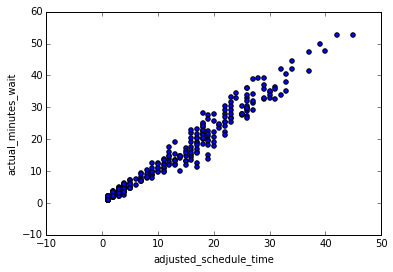

In [30]:
time_differences.plot(x="adjusted_schedule_time", y="actual_minutes_wait", kind="scatter")

So the estimates are generally within a couple minutes up to about 13 minutes out, at which point they start to get less reliable. Overall the correlation is pretty good.